In [36]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
import matplotlib.pyplot as plt

In [37]:
df = pd.read_csv('ENGI_1-6000.csv')
columns_to_drop = ['subject_area_names', 'title', 'subject_area_abbrevs', 'zeroCitesSCE_2022', 'publisher', 'zeroCitesSCE_2023', 'zeroCitesSCE_2024',
                   'revPercent_2022', 'revPercent_2023', 'revPercent_2024', 'SNIP']
df_sjr = df.drop(columns_to_drop, axis=1)
nominal = ['aggregationType']
dummy = pd.get_dummies(df_sjr[nominal], drop_first=True)
df_sjr = pd.concat([df_sjr, dummy], axis=1)
df_sjr = df_sjr.drop(nominal, axis=1)
df_sjr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3179 entries, 0 to 3178
Data columns (total 12 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   SJR                                   3179 non-null   float64
 1   publicationCount_2022                 3179 non-null   int64  
 2   citeCountSCE_2022                     3179 non-null   int64  
 3   publicationCount_2023                 3179 non-null   int64  
 4   citeCountSCE_2023                     3179 non-null   int64  
 5   publicationCount_2024                 3179 non-null   int64  
 6   citeCountSCE_2024                     3179 non-null   int64  
 7   citeScoreTracker_2024                 3179 non-null   float64
 8   citeScoreCurrentMetric_2023           3179 non-null   float64
 9   aggregationType_conferenceproceeding  3179 non-null   bool   
 10  aggregationType_journal               3179 non-null   bool   
 11  aggregationType_t

In [38]:
for col in df_sjr.select_dtypes(include='number').columns:
    if str(col) == 'SJR':
        continue
    else:
        q1 = df_sjr[col].quantile(0.25)
        q3 = df_sjr[col].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr
        df_sjr[col] = df_sjr[col].apply(lambda x: q1 if x < q1 else q3 if x > q3 else x)

{'criterion': 'friedman_mse', 'max_depth': 3, 'min_samples_leaf': 5, 'n_estimators': 100, 'random_state': 2024}
                                      Coefficient
publicationCount_2022                   -0.001266
citeCountSCE_2022                       -0.000136
publicationCount_2023                    0.000282
citeCountSCE_2023                       -0.000003
publicationCount_2024                    0.000364
citeCountSCE_2024                        0.000264
citeScoreTracker_2024                    0.111916
citeScoreCurrentMetric_2023              0.095677
aggregationType_conferenceproceeding     0.076945
aggregationType_journal                  0.002370
aggregationType_tradejournal             0.063525
                                      Coefficient
publicationCount_2022                    0.046997
citeCountSCE_2022                        0.005879
publicationCount_2023                    0.006531
citeCountSCE_2023                        0.001653
publicationCount_2024                 

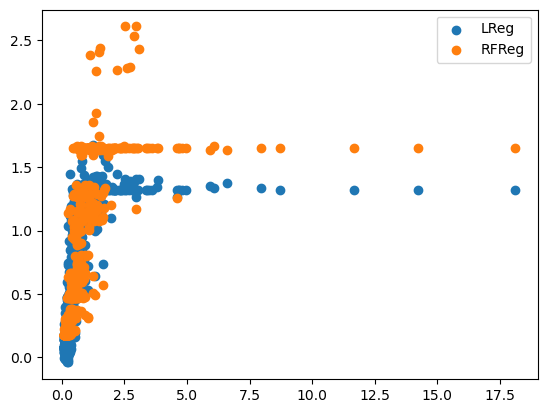

In [41]:
x = df_sjr.drop(['SJR'], axis=1)
y = df_sjr['SJR']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=2024)

scaler = StandardScaler()

linear = LinearRegression()
linear.fit(x_train, y_train)
pred = linear.predict(x_test)

tree = RandomForestRegressor()
grid = GridSearchCV(
    estimator=tree,
    param_grid={
        'n_estimators': [100],
        'criterion': ['squared_error', 'friedman_mse'],
        "max_depth":[2,3],
        "min_samples_leaf":[2,5],
        'random_state': [2024],
    },
    n_jobs=-1,
    cv=5
)

grid.fit(x_train, y_train)
pred2 = grid.predict(x_test)


plt.scatter(y_test, pred, label='LReg')

plt.scatter(y_test, pred2, label='RFReg')
plt.legend()
print(grid.best_params_)

coef_linear = pd.DataFrame(linear.coef_, linear.feature_names_in_, columns=["Coefficient"])
coef_rf = pd.DataFrame(grid.best_estimator_.feature_importances_, grid.feature_names_in_, columns=["Coefficient"])

print(coef_linear)
print(coef_rf)



In [40]:
df[['publicationCount_2022','publicationCount_2023','publicationCount_2024','citeCountSCE_2022','citeCountSCE_2023','citeCountSCE_2024','citeScoreTracker_2024','citeScoreCurrentMetric_2023', 'SJR']]

,publicationCount_2022,publicationCount_2023,publicationCount_2024,citeCountSCE_2022,citeCountSCE_2023,citeCountSCE_2024,citeScoreTracker_2024,citeScoreCurrentMetric_2023,SJR
0,162,159,145,9669,9449,8743,8.6,10.7,1.483
1,49,134,195,1642,1885,1842,4.7,6.0,0.646
2,277,188,161,9,6,2,0.0,0.0,0.100
3,102,163,41,17,17,28,0.1,0.0,0.105
4,120,41,52,8204,8173,6805,3.8,3.6,0.753
...,...,...,...,...,...,...,...,...,...
3174,50,18,33,33,34,22,0.2,0.2,0.100
3175,87,74,68,2931,3795,4346,14.8,14.5,2.460
3176,262,229,248,9192,11725,13942,15.3,15.3,2.447
3177,100,53,71,1995,3105,3980,19.0,17.1,2.969
